In [8]:
import torch
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available!
Device Name: Tesla T4


Compiling model...
Building feed-forward neural network...
'build' took 0.125685 s

'compile' took 0.795627 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.06e+01, 9.59e-02]    [3.66e+01, 9.59e-02]    [1.14e+00]    
1000      [3.88e-03, 7.36e-03]    [3.09e-03, 7.36e-03]    [1.70e-01]    
2000      [6.02e-04, 1.28e-03]    [6.04e-04, 1.28e-03]    [6.89e-02]    
3000      [2.55e-04, 5.33e-04]    [2.40e-04, 5.33e-04]    [4.43e-02]    
4000      [4.04e-04, 2.98e-04]    [4.24e-04, 2.98e-04]    [3.37e-02]    
5000      [9.43e-04, 2.13e-04]    [8.39e-04, 2.13e-04]    [2.90e-02]    
6000      [4.83e-03, 2.65e-04]    [5.07e-03, 2.65e-04]    [3.54e-02]    
7000      [1.28e-04, 1.04e-04]    [1.19e-04, 1.04e-04]    [2.00e-02]    
8000      [1.58e-04, 7.96e-05]    [1.43e-04, 7.96e-05]    [1.70e-02]    
9000      [4.92e-04, 6.81e-05]    [5.41e-04, 6.81e-05]    [1.57e-02]    
10000     [5.77e-04, 6.12e-05]    [4.82e-04, 6.12e-05]    [1.49e-02

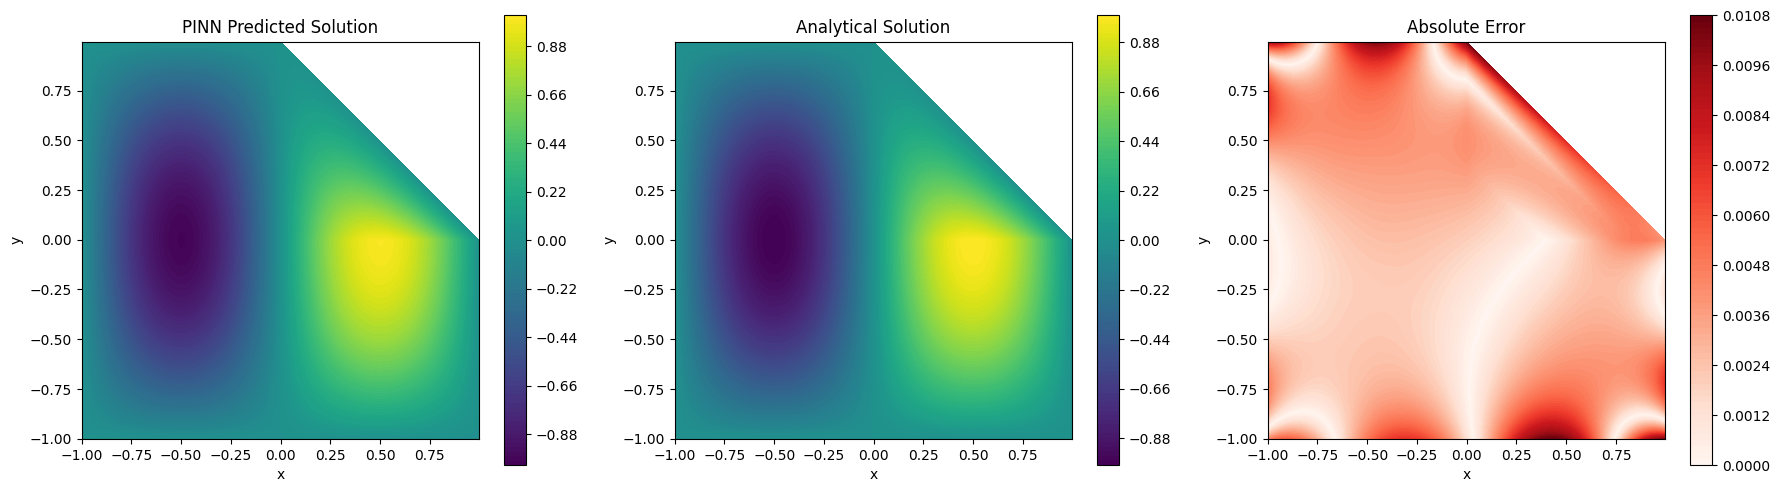

Final L2 relative error: 6.4692e-03


In [14]:
# Install deepxde if you haven't already
# !pip install deepxde

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import deepxde as dde
import os

# Set the backend to PyTorch
os.environ['DDE_BACKEND'] = 'pytorch'

# --- 1. Define the Problem: Geometry, PDE, and Boundary Conditions ---

# Define the L-shaped domain using the vertices of a polygon.
# The domain is the square [-1, 1] x [-1, 1] with the quadrant [0, 1] x [-1, 0] removed.
# The re-entrant corner is at (0, 0), which introduces a singularity.
vertices = [[-1, -1], [1, -1], [1, 0], [0, 0], [0, 1], [-1, 1]]
geom = dde.geometry.Polygon(vertices)

# Define the Poisson equation.
# The forcing function f(x, y) is derived from a known analytical solution.
def pde(x, u):
    """
    Defines the residual of the Poisson equation: ∇²u - f = 0.

    Args:
        x: A tensor of coordinates (x, y) with shape [N, 2].
        u: The network's output tensor u(x, y) with shape [N, 1].

    Returns:
        The PDE residual tensor.
    """
    # Calculate the Laplacian of u using automatic differentiation.
    # dde.grad.hessian(u, x, i=0, j=0) computes ∂²u/∂x²
    # dde.grad.hessian(u, x, i=1, j=1) computes ∂²u/∂y²
    dudx2 = dde.grad.hessian(u, x, i=0, j=0)
    dudy2 = dde.grad.hessian(u, x, i=1, j=1)
    laplacian = dudx2 + dudy2

    # Coordinates are extracted for clarity.
    x_ = x[:, 0:1]
    y_ = x[:, 1:2]

    # Forcing function f(x, y) = - (5/4)π² * sin(πx) * cos(πy / 2)
    pi = np.pi
    forcing_term = -(5.0 / 4.0) * pi**2 * dde.backend.sin(pi * x_) * dde.backend.cos(pi * y_ / 2.0)

    return laplacian - forcing_term

# Define the analytical solution used for validation and boundary conditions.
def analytical_solution(x):
    """
    Analytical solution u(x, y) = sin(πx) * cos(πy / 2).

    Args:
        x: A NumPy array of coordinates with shape [N, 2].

    Returns:
        The solution u at each coordinate.
    """
    x_, y_ = x[:, 0:1], x[:, 1:2]
    return np.sin(np.pi * x_) * np.cos(np.pi * y_ / 2.0)

# Define the boundary condition function.
# This function must return the correct value of u for any point on the boundary.
def boundary_func(x):
    """
    Computes the boundary values from the analytical solution.
    This handles the non-homogeneous part of the Dirichlet condition.
    """
    return analytical_solution(x)

# Create the Dirichlet Boundary Condition object.
# The lambda function `lambda _, on_boundary: on_boundary` applies this condition
# to all points identified by deepxde as being on the boundary of the geometry.
bc = dde.DirichletBC(geom, boundary_func, lambda _, on_boundary: on_boundary)


# --- 2. Create the Model and Data ---

# Create the PDE data object.
# num_domain: Number of points inside the domain to enforce the PDE residual.
# num_boundary: Number of points on the boundary to enforce the BCs.
# solution: The analytical solution used to compute the error metric during training.
# num_test: Number of points for calculating the final validation error.
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=2500,
    num_boundary=800,
    solution=analytical_solution,
    num_test=1000,
)

# Define the neural network architecture.
# Input: 2 neurons (x, y)
# Hidden Layers: 4 layers with 50 neurons each, using the 'tanh' activation function.
# Output: 1 neuron (u)
net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot normal")

# Create the deepxde model.
model = dde.Model(data, net)


# --- 3. Train the Model ---

# Compile the model with the Adam optimizer and set the L2 relative error as a metric.
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

# Refine the model using the L-BFGS optimizer for higher accuracy.
model.compile("L-BFGS")
losshistory, train_state = model.train()


# --- 4. Visualize the Results ---

print("\n--- Generating final plots ---")

# Generate a dense grid of points for plotting.
# We generate points in the bounding box and then keep only those inside the L-shaped domain.
n_points = 500
x_range = np.linspace(-1, 1, n_points)
y_range = np.linspace(-1, 1, n_points)
grid_x, grid_y = np.meshgrid(x_range, y_range)
plot_points = np.hstack((grid_x.flatten()[:, None], grid_y.flatten()[:, None]))
is_inside = geom.inside(plot_points)
plot_points = plot_points[is_inside]

# Make predictions on the plot points.
u_pred = model.predict(plot_points)
# Calculate the true solution and the point-wise error.
u_true = analytical_solution(plot_points)
error = np.abs(u_pred - u_true)

# Create a triangulation for the unstructured data for contour plotting.
triang = tri.Triangulation(plot_points[:, 0], plot_points[:, 1])

# Create a figure with three subplots.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Predicted Solution
contour1 = axes[0].tricontourf(triang, u_pred.flatten(), levels=100, cmap='viridis')
fig.colorbar(contour1, ax=axes[0])
axes[0].set_title('PINN Predicted Solution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_aspect('equal', 'box')

# Plot 2: Analytical Solution
contour2 = axes[1].tricontourf(triang, u_true.flatten(), levels=100, cmap='viridis')
fig.colorbar(contour2, ax=axes[1])
axes[1].set_title('Analytical Solution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_aspect('equal', 'box')

# Plot 3: Absolute Error
contour3 = axes[2].tricontourf(triang, error.flatten(), levels=100, cmap='Reds')
fig.colorbar(contour3, ax=axes[2])
axes[2].set_title('Absolute Error')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_aspect('equal', 'box')

plt.tight_layout()
plt.savefig("poisson_l_shape_solution.png")
plt.show()

# Finally, print the L2 relative error on the test data.
final_error = dde.metrics.l2_relative_error(u_true, u_pred)
print(f"Final L2 relative error: {final_error:.4e}")


Compiling model...
Building feed-forward neural network...
'build' took 0.110293 s

'compile' took 1.231727 s

--- Starting Adam optimization ---
Training model...

Step      Train loss              Test loss               Test metric   
0         [3.10e+01, 6.63e-02]    [3.90e+01, 6.63e-02]    [9.01e-01]    
Epoch 1: train loss improved from inf to 3.11e+01, saving model to model/best_model.pt-1.ckpt ...

1000      [3.56e-03, 9.03e-03]    [2.64e-03, 9.03e-03]    [1.87e-01]    
Epoch 1000: train loss improved from 3.11e+01 to 1.26e-02, saving model to model/best_model.pt-1000.ckpt ...

2000      [6.62e-04, 2.35e-03]    [6.37e-04, 2.35e-03]    [9.24e-02]    
Epoch 2000: train loss improved from 1.26e-02 to 3.01e-03, saving model to model/best_model.pt-2000.ckpt ...

3000      [3.20e-04, 9.50e-04]    [2.62e-04, 9.50e-04]    [5.85e-02]    
Epoch 3000: train loss improved from 3.01e-03 to 1.27e-03, saving model to model/best_model.pt-3000.ckpt ...

4000      [3.92e-04, 4.21e-04]    [3.80e-

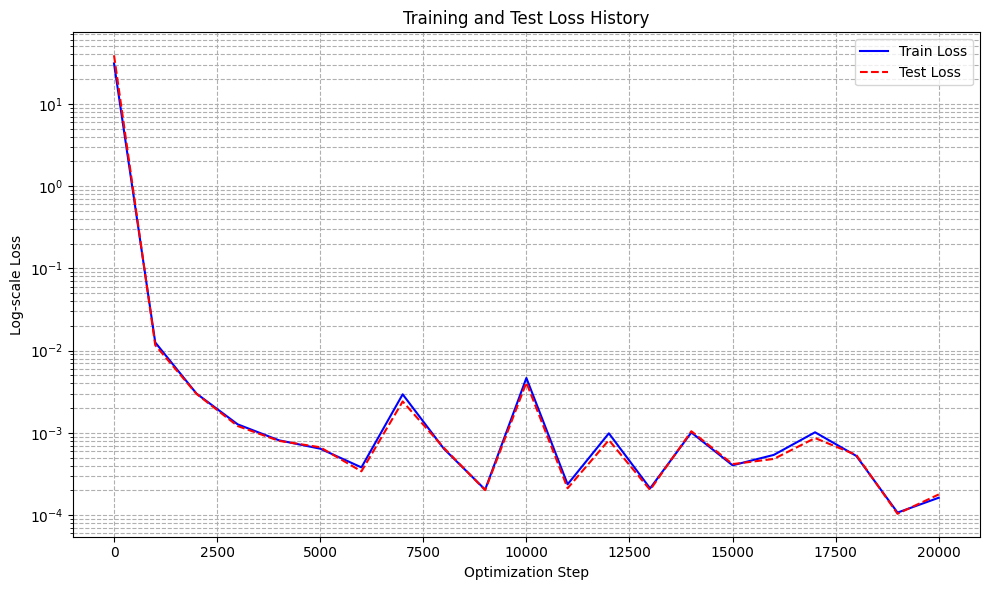


--- Starting L-BFGS optimization (loading best model) ---
Compiling model...
'compile' took 0.423767 s

Training model...

Step      Train loss              Test loss               Test metric
20000     [1.33e-04, 3.00e-05]    [1.49e-04, 3.00e-05]    []  
20020     [1.33e-04, 3.00e-05]    [1.49e-04, 3.00e-05]    []  

Best model at step 19000:
  train loss: 1.07e-04
  test loss: 1.04e-04
  test metric: [1.03e-02]

'train' took 3.600092 s


--- Generating final plots ---


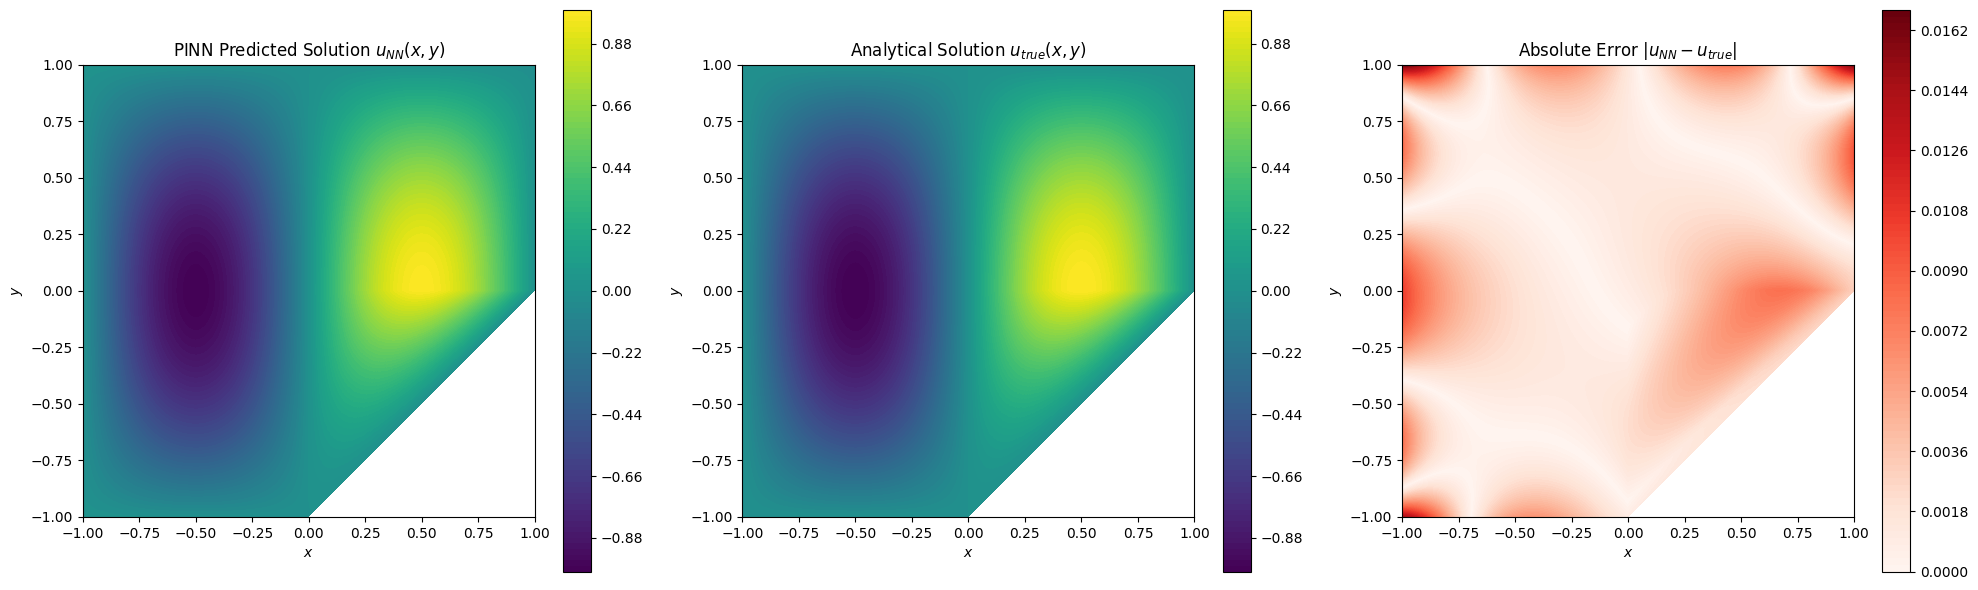


Final L2 relative error on test data: 1.0160e-02


In [7]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# Set the backend to PyTorch
os.environ['DDE_BACKEND'] = 'pytorch'

# --- 1. Configuration and Setup ---

# Set the backend to PyTorch for consistency. DeepXDE supports TensorFlow and JAX as well.
# Set a random seed for reproducibility of results.
dde.config.set_random_seed(42)

# --- 2. Problem Definition: Geometry, PDE, and Boundary Conditions ---

def create_geometry() -> dde.geometry.CSGDifference:
    """
    Defines the L-shaped domain using Constructive Solid Geometry (CSG).
    The domain is the square [-1, 1] x [-1, 1] with the bottom-right
    quadrant [0, 1] x [-1, 0] removed. The re-entrant corner at (0, 0) is a
    classical source of singularities for the Laplace equation, making this a
    benchmark problem.

    Returns:
        dde.geometry.CSGDifference: The L-shaped geometry object.
    """
    # Define the large square: [-1, 1] x [-1, 1]
    geom1 = dde.geometry.Rectangle(xmin=[-1, -1], xmax=[1, 1])
    # Define the smaller square to be subtracted: [0, 1] x [-1, 0]
    geom2 = dde.geometry.Rectangle(xmin=[0, -1], xmax=[1, 0])
    # The L-shaped domain is the difference between the two geometries.
    return dde.geometry.CSGDifference(geom1, geom2)

def pde(x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    """
    Defines the residual of the Poisson equation: ∇²u - f = 0.

    The forcing function f(x, y) is chosen such that the analytical solution
    is known, allowing for rigorous validation of the PINN model.
    f(x, y) = - (5/4)π² * sin(πx) * cos(πy / 2)

    Args:
        x: A tensor of coordinates (x, y) with shape [N, 2].
        u: The network's output tensor u(x, y) with shape [N, 1].

    Returns:
        torch.Tensor: The PDE residual tensor of shape [N, 1].
    """
    # The dde.grad.laplacian helper is not available in all library versions.
    # We compute the Laplacian manually by summing the second partial derivatives
    # calculated using the hessian function for broader compatibility.
    dudx2 = dde.grad.hessian(u, x, i=0, j=0)  # Computes ∂²u/∂x²
    dudy2 = dde.grad.hessian(u, x, i=1, j=1)  # Computes ∂²u/∂y²
    laplacian = dudx2 + dudy2

    x_, y_ = x[:, 0:1], x[:, 1:2]

    # Define the forcing term f(x, y)
    pi = np.pi
    forcing_term = -(5.0 / 4.0) * pi**2 * dde.backend.sin(pi * x_) * dde.backend.cos(pi * y_ / 2.0)

    return laplacian - forcing_term

def analytical_solution(x: np.ndarray) -> np.ndarray:
    """
    Defines the analytical solution u(x, y) = sin(πx) * cos(πy / 2).

    This function is used to specify the non-homogeneous Dirichlet boundary
    conditions and to compute the final error metric for validation.

    Args:
        x: A NumPy array of coordinates with shape [N, 2].

    Returns:
        np.ndarray: The exact solution u at each coordinate, shape [N, 1].
    """
    x_, y_ = x[:, 0:1], x[:, 1:2]
    return np.sin(np.pi * x_) * np.cos(np.pi * y_ / 2.0)

# --- 3. Model Training and Visualization Functions ---

def plot_loss_history(losshistory) -> None:
    """
    Plots the evolution of training and testing losses over optimization steps.

    Args:
        losshistory: The history object returned by model.train(). The specific
                     class type hint is omitted to ensure compatibility across
                     different DeepXDE versions where its location has changed.
    """
    loss_train = np.sum(losshistory.loss_train, axis=1)
    loss_test = np.sum(losshistory.loss_test, axis=1)
    steps = losshistory.steps

    plt.figure(figsize=(10, 6))
    plt.plot(steps, loss_train, label='Train Loss', color='blue')
    plt.plot(steps, loss_test, label='Test Loss', color='red', linestyle='--')
    plt.yscale('log')
    plt.title('Training and Test Loss History')
    plt.xlabel('Optimization Step')
    plt.ylabel('Log-scale Loss')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig("poisson_l_shape_loss_history.png")
    plt.show()

def plot_results(model: dde.Model, geom: dde.geometry.CSGDifference) -> None:
    """
    Generates and plots the PINN prediction, analytical solution, and error.

    Args:
        model: The trained DeepXDE model.
        geom: The problem geometry for sampling points.
    """
    print("\n--- Generating final plots ---")
    n_points = 500
    x_range = np.linspace(-1, 1, n_points)
    y_range = np.linspace(-1, 1, n_points)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    plot_points = np.hstack((grid_x.flatten()[:, None], grid_y.flatten()[:, None]))

    # Keep only points that are inside the L-shaped domain
    is_inside = geom.inside(plot_points)
    plot_points = plot_points[is_inside]

    # Predict solution and compute error
    u_pred = model.predict(plot_points)
    u_true = analytical_solution(plot_points)
    error = np.abs(u_pred - u_true)

    # Use triangulation for plotting unstructured data
    triang = plt.matplotlib.tri.Triangulation(plot_points[:, 0], plot_points[:, 1])

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    levels = np.linspace(min(u_true.min(), u_pred.min()), max(u_true.max(), u_pred.max()), 101)

    # Plot 1: PINN Predicted Solution
    contour1 = axes[0].tricontourf(triang, u_pred.flatten(), levels=levels, cmap='viridis')
    fig.colorbar(contour1, ax=axes[0])
    axes[0].set_title('PINN Predicted Solution $u_{NN}(x,y)$')
    axes[0].set_xlabel('$x$')
    axes[0].set_ylabel('$y$')
    axes[0].set_aspect('equal', 'box')

    # Plot 2: Analytical Solution
    contour2 = axes[1].tricontourf(triang, u_true.flatten(), levels=levels, cmap='viridis')
    fig.colorbar(contour2, ax=axes[1])
    axes[1].set_title('Analytical Solution $u_{true}(x,y)$')
    axes[1].set_xlabel('$x$')
    axes[1].set_ylabel('$y$')
    axes[1].set_aspect('equal', 'box')

    # Plot 3: Absolute Error
    contour3 = axes[2].tricontourf(triang, error.flatten(), levels=100, cmap='Reds')
    fig.colorbar(contour3, ax=axes[2])
    axes[2].set_title('Absolute Error $|u_{NN} - u_{true}|$')
    axes[2].set_xlabel('$x$')
    axes[2].set_ylabel('$y$')
    axes[2].set_aspect('equal', 'box')

    plt.tight_layout()
    plt.savefig("poisson_l_shape_solution_comparison.png")
    plt.show()

# --- 4. Main Execution Block ---

def main() -> None:
    """Main function to set up and run the PINN simulation."""

    # --- Define Geometry and Boundary Conditions ---
    geom = create_geometry()

    # Boundary condition is Dirichlet, applied to all points on the boundary.
    # The values are taken from the analytical solution.
    bc = dde.DirichletBC(
        geom,
        analytical_solution,
        lambda _, on_boundary: on_boundary
    )

    # --- Create Data and Model ---
    # Collocation points are sampled for enforcing the PDE and BCs.
    data = dde.data.PDE(
        geom,
        pde,
        bc,
        num_domain=2500,        # Points inside the domain for PDE residual
        num_boundary=800,       # Points on the boundary for BC enforcement
        solution=analytical_solution,
        num_test=1000,          # Points for calculating validation error
    )

    # Define the Fully Connected Network (FNN) architecture.
    # Input: 2 neurons (x, y)
    # Hidden Layers: 4 layers with 50 neurons each, using 'tanh' activation.
    # Output: 1 neuron (u)
    # The "Glorot normal" initializer is a standard choice for deep networks.
    net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot normal")

    model = dde.Model(data, net)

    # --- Train the Model ---

    # Stage 1: Adam optimizer.
    # Adam is a robust first-order optimizer, well-suited for navigating the
    # complex loss landscape in the initial phases of training.
    model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

    # Checkpoint callback saves the model with the minimum training loss.
    # This ensures that we proceed to the L-BFGS stage with the best possible model.
    checkpointer = dde.callbacks.ModelCheckpoint(
        "model/best_model.pt", save_better_only=True, verbose=True
    )

    print("--- Starting Adam optimization ---")
    adam_losshistory, train_state = model.train(iterations=20000, callbacks=[checkpointer])

    # Plot the loss history from the Adam optimization phase.
    plot_loss_history(adam_losshistory)

    # Stage 2: L-BFGS optimizer.
    # L-BFGS is a quasi-Newton method that often converges faster and to a better
    # minimum in the final stages of training (fine-tuning). It is computationally
    # more expensive per step, hence it's used after Adam.
    print("\n--- Starting L-BFGS optimization (loading best model) ---")
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    # --- Visualize Results and Finalize ---
    plot_results(model, geom)

    # Calculate and print the final L2 relative error on the test data.
    u_pred = model.predict(data.test_x)
    u_true = data.test_y
    final_error = dde.metrics.l2_relative_error(u_true, u_pred)
    print(f"\nFinal L2 relative error on test data: {final_error:.4e}")

if __name__ == "__main__":
    main()